In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns

Pour cette question, on introduit un temps $t_b$ pour bloquer la moulinette de la population ING. Cette dernière sera ouverte pendant un temps de $\frac{t_b}{2}$ puis bloqué pendant un temps $t_b$ et ainsi de suite.

In [8]:
class mmk_finite_two_populations_and_dams():
    """
    Classe représentant un système de file M/M/K avec une taille de file finie, pour deux populations (ING, PREPA) 
    avec un barrage pour une population.

    Attributs:
        lamda_ing (float): Taux d'arrivée de la population ING
        lamda_prepa (float): Taux d'arrivée de la population PREPA
        mu_ing (float): Taux de service de la population ING
        mu_prepa (float): Taux de service de la population PREPA
        k (int): Nombre de serveurs
        Ks (int): Taille maximum de la file (SANS compter les serveurs)
        gen (np.random): Générateur de nombre random
        test_z (int): Nombre de pushes à simuler
        refused_pushes_ing (int): Pushes refusés pour la population ING
        refused_pushes_prepa (int): Pushes refusés pour la population PREPA
        tops (pd.DataFrame): données de timing pour chaque push
        t_blocage (int): temps de blocage
    """
    
    def __init__(self, lamda_ing, lamda_prepa, mu_ing, mu_prepa, k, Ks, gen, t_blocage, test_z=100):
        """
        Initialisation du système de file M/M/K avec une taille de file finie pour deux populations.

        Args:
            lamda_ing: Taux d'arrivée de la population ING
            lamda_prepa: Taux d'arrivée de la population PREPA
            mu_ing: Taux de service de la population ING
            mu_prepa: Taux de service de la population PREPA
            k: Nombre de serveurs
            Ks: Taille maximum de la file (SANS compter les serveurs)
            gen: Générateur de nombre random
            test_z: Nombre de pushes à simuler
            t_blocage : temps de blocage
        """
        # Paramètres de la file
        self.lamda_ing = lamda_ing
        self.lamda_prepa = lamda_prepa
        self.mu_ing = mu_ing
        self.mu_prepa = mu_prepa
        self.k = k
        self.Ks = Ks
        self.gen = gen
        self.t_size = test_z
        self.t_blocage = t_blocage
        self.refused_pushes_ing = 0
        self.refused_pushes_prepa = 0
        
        # Initialisation du Dataframe temporel
        self.tops = pd.DataFrame(
            index=range(test_z),
            columns=['t_arrival', 't_service_start', 't_departure', 'population'],
            data=np.zeros((test_z, 4))
        )
        
    def run(self):
        """
        Simule le système de file M/M/K avec une taille finie pour deux populations.
        """
        print("Lancement de la simulation M/M/K pour deux populations")
        
         # Ajout des colonnes temporelles
        self.tops["t_waiting"] = np.zeros(self.t_size)
        self.tops["t_service"] = np.zeros(self.t_size)
        self.tops["t_sojourn"] = np.zeros(self.t_size)
        
        # Ajout de la colonne pour traquer le nombre de rejet
        self.tops["rejected"] = np.zeros(self.t_size)
        
        # Traque la disponibilité des serveurs
        server_available = np.zeros(self.k)
        
        # Gènère les temps d'arrivée pour les deux population
        arrivals_ing = np.cumsum(self.gen.exponential(1 / self.lamda_ing, self.t_size // 2))
        arrivals_prepa = np.cumsum(self.gen.exponential(1 / self.lamda_prepa, self.t_size // 2))
        
        # Merge et tri des temps d'arrivée + ajout des labels de population
        arrivals = np.concatenate((arrivals_ing, arrivals_prepa))
        populations = ['ING'] * len(arrivals_ing) + ['PREPA'] * len(arrivals_prepa)
        combined = sorted(zip(arrivals, populations))

        is_blocking = True  # Commence dans l'êtat bloquant
        block_start_time = 0
        block_period = self.t_blocage  # Temps total de blocquage
        unblock_period = self.t_blocage / 2
        
        # Traitement des pushs
        for i, (arrival_time, population) in enumerate(combined):
            current_time = arrival_time

            time_since_block_start = current_time - block_start_time
            if is_blocking and time_since_block_start >= block_period:
                is_blocking = False
                block_start_time = current_time
            elif not is_blocking and time_since_block_start >= unblock_period:
                is_blocking = True
                block_start_time = current_time

            if is_blocking and population == 'ING':
                self.refused_pushes_ing += 1
                self.tops.loc[i, "rejected"] = 1
                continue 

            self.tops.loc[i, "t_arrival"] = arrival_time
            self.tops.loc[i, "population"] = population
            
            # Compte les pushs actuellement dans la filee
            current_time = arrival_time
            in_queue = ((self.tops["t_arrival"] <= current_time) & 
                       (self.tops["t_service_start"] > current_time)).sum()
            
            # Vérifie si la limite de taille de la file d'attente est atteinte
            if in_queue >= self.Ks:
                if population == 'ING':
                    self.refused_pushes_ing += 1
                else:
                    self.refused_pushes_prepa += 1
                self.tops.loc[i, "rejected"] = 1
                continue
                
            # Trouve le premier serveur disponible
            server_idx = np.argmin(server_available)
            
            # Calcule le début du temps de service
            self.tops.loc[i, "t_service_start"] = max(server_available[server_idx], arrival_time)
            
            # Calcule le temps d'attente et de service
            self.tops.loc[i, "t_waiting"] = self.tops.loc[i, "t_service_start"] - arrival_time
            if population == 'ING':
                self.tops.loc[i, "t_service"] = self.gen.exponential(1 / self.mu_ing)
            else:
                self.tops.loc[i, "t_service"] = self.gen.exponential(1 / self.mu_prepa)
            
            # Calcule le temps de départ
            self.tops.loc[i, "t_departure"] = self.tops.loc[i, "t_service_start"] + self.tops.loc[i, "t_service"]
            self.tops.loc[i, "t_sojourn"] = self.tops.loc[i, "t_waiting"] + self.tops.loc[i, "t_service"]
            
            # Met à jour la disponibilité des serveurs
            server_available[server_idx] = self.tops.loc[i, "t_departure"]

    def counts(self, t_intervals, population= "BOTH"):
        """
        Calcule le nombre de push dans le système à des intervalles de temps régulier
        
        Args:
            t_intervals: L'intervalle de temps pour les mesures
            population: Le type de population étudiée (BOTH pour les deux, PREPA ou ING pour l'étude d'une population en particulier)
            
        Returns:
            Dataframe avec le nombre de push dans le système, dans la file d'attente, en service et rejeté
        """
        t_max = self.tops["t_departure"].max()
        t_points = np.arange(0, t_max, t_intervals)
        last_t = 0
        
        counts = pd.DataFrame(
            index=t_points,
            columns=['ag_in_sys', 'ag_in_queue', 'ag_in_service', 'rejected'],
            data=np.zeros((len(t_points), 4))
        )

        if (population == "BOTH"):
            for t in t_points:
                in_sys = ((self.tops["t_arrival"] <= t) & (self.tops["t_departure"] > t)).sum()
                in_queue = ((self.tops["t_arrival"] <= t) & (self.tops["t_service_start"] > t)).sum()
                in_service = ((self.tops["t_service_start"] <= t) & (self.tops["t_departure"] > t)).sum()
                rejected = ((self.tops["t_arrival"] <= t) & (self.tops["t_arrival"] > last_t) & (self.tops["rejected"] == 1)).sum()
                
                counts.loc[t] = [in_sys, in_queue, in_service, rejected]
                last_t = t
        
        else:
            filtered_tops = self.tops[self.tops["population"] == population]

            for t in t_points:
                in_sys = ((filtered_tops["t_arrival"] <= t) & (filtered_tops["t_departure"] > t)).sum()
                in_queue = ((filtered_tops["t_arrival"] <= t) & (filtered_tops["t_service_start"] > t)).sum()
                in_service = ((filtered_tops["t_service_start"] <= t) & (filtered_tops["t_departure"] > t)).sum()
                rejected = ((filtered_tops["t_arrival"] <= t) & (filtered_tops["t_arrival"] > last_t) & (filtered_tops["rejected"] == 1)).sum()
                
                counts.loc[t] = [in_sys, in_queue, in_service, rejected]
                last_t = t
        return counts
    
    def stats(self):
        """
        Crèe un résumé de statistiques pour les deux populations.
        
        Returns:
            Dataframe avec des statistiques pour chaque population
        """
        stats_ing = self.tops[self.tops["population"] == 'ING'][["t_waiting", "t_service", "t_sojourn"]].mean()
        stats_prepa = self.tops[self.tops["population"] == 'PREPA'][["t_waiting", "t_service", "t_sojourn"]].mean()
        
        stats = pd.DataFrame({
            'Population': ['ING', 'PREPA'],
            'Mean Waiting Time': [stats_ing["t_waiting"], stats_prepa["t_waiting"]],
            'Mean Service Time': [stats_ing["t_service"], stats_prepa["t_service"]],
            'Mean Sojourn Time': [stats_ing["t_sojourn"], stats_prepa["t_sojourn"]],
            'Refused Pushes': [self.refused_pushes_ing, self.refused_pushes_prepa]
        })
        
        return stats

In [7]:
class mmk_finite_two_populations():
    """
    Classe représentant un système de file M/M/K avec une taille de file finie, pour deux populations (ING, PREPA).

    Attributs:
        lamda_ing (float): Taux d'arrivée de la population ING
        lamda_prepa (float): Taux d'arrivée de la population PREPA
        mu_ing (float): Taux de service de la population ING
        mu_prepa (float): Taux de service de la population PREPA
        k (int): Nombre de serveurs
        Ks (int): Taille maximum de la file (SANS compter les serveurs)
        gen (np.random): Générateur de nombre random
        test_z (int): Nombre de pushes à simuler
        refused_pushes_ing (int): Pushes refusés pour la population ING
        refused_pushes_prepa (int): Pushes refusés pour la population PREPA
        tops (pd.DataFrame): données de timing pour chaque push
    """
    
    def __init__(self, lamda_ing, lamda_prepa, mu_ing, mu_prepa, k, Ks, gen, test_z=100):
        """
        Initialisation du système de file M/M/K avec une taille de file finie pour deux populations.

        Args:
            lamda_ing: Taux d'arrivée de la population ING
            lamda_prepa: Taux d'arrivée de la population PREPA
            mu_ing: Taux de service de la population ING
            mu_prepa: Taux de service de la population PREPA
            k: Nombre de serveurs
            Ks: Taille maximum de la file (SANS compter les serveurs)
            gen: Générateur de nombre random
            test_z: Nombre de pushes à simuler
        """
        # Paramètres de la file
        self.lamda_ing = lamda_ing
        self.lamda_prepa = lamda_prepa
        self.mu_ing = mu_ing
        self.mu_prepa = mu_prepa
        self.k = k
        self.Ks = Ks
        self.gen = gen
        self.t_size = test_z
        self.refused_pushes_ing = 0
        self.refused_pushes_prepa = 0
        
        # Initialisation du Dataframe temporel
        self.tops = pd.DataFrame(
            index=range(test_z),
            columns=['t_arrival', 't_service_start', 't_departure', 'population'],
            data=np.zeros((test_z, 4))
        )
        
    def run(self):
        """
        Simule le système de file M/M/K avec une taille finie pour deux populations.
        """
        print("Lancement de la simulation M/M/K pour deux populations")
        
        # Ajout des colonnes temporelles
        self.tops["t_waiting"] = np.zeros(self.t_size)
        self.tops["t_service"] = np.zeros(self.t_size)
        self.tops["t_sojourn"] = np.zeros(self.t_size)

        # Ajout de la colonne pour traquer le nombre de rejet
        self.tops["rejected"] = np.zeros(self.t_size)
        
        # Traque la disponibilité des serveurs
        server_available = np.zeros(self.k)
        
        # Gènère les temps d'arrivée pour les deux population
        arrivals_ing = np.cumsum(self.gen.exponential(1 / self.lamda_ing, self.t_size // 2))
        arrivals_prepa = np.cumsum(self.gen.exponential(1 / self.lamda_prepa, self.t_size // 2))
        
        # Merge et tri des temps d'arrivée + ajout des labels de population
        arrivals = np.concatenate((arrivals_ing, arrivals_prepa))
        populations = ['ING'] * len(arrivals_ing) + ['PREPA'] * len(arrivals_prepa)
        combined = sorted(zip(arrivals, populations))
        
        # Traitement des pushs
        for i, (arrival_time, population) in enumerate(combined):
            self.tops.loc[i, "t_arrival"] = arrival_time
            self.tops.loc[i, "population"] = population
            
            # Compte les pushs actuellement dans la file
            current_time = arrival_time
            in_queue = ((self.tops["t_arrival"] <= current_time) & 
                       (self.tops["t_service_start"] > current_time)).sum()
            
            # Vérifie si la limite de taille de la file d'attente est atteinte
            if in_queue >= self.Ks:
                if population == 'ING':
                    self.refused_pushes_ing += 1
                else:
                    self.refused_pushes_prepa += 1
                self.tops.loc[i, "rejected"] = 1
                continue
                
            # Trouve le premier serveur disponible
            server_idx = np.argmin(server_available)
            
            # Calcule le début du temps de service
            self.tops.loc[i, "t_service_start"] = max(server_available[server_idx], arrival_time)
            
            # Calcule le temps d'attente et de service
            self.tops.loc[i, "t_waiting"] = self.tops.loc[i, "t_service_start"] - arrival_time
            if population == 'ING':
                self.tops.loc[i, "t_service"] = self.gen.exponential(1 / self.mu_ing)
            else:
                self.tops.loc[i, "t_service"] = self.gen.exponential(1 / self.mu_prepa)
            
            # Calcule le temps de départ
            self.tops.loc[i, "t_departure"] = self.tops.loc[i, "t_service_start"] + self.tops.loc[i, "t_service"]
            self.tops.loc[i, "t_sojourn"] = self.tops.loc[i, "t_waiting"] + self.tops.loc[i, "t_service"]
            
            # Met à jour la disponibilité des serveurs
            server_available[server_idx] = self.tops.loc[i, "t_departure"]

    def counts(self, t_intervals, population= "BOTH"):
        """
        Calcule le nombre de push dans le système à des intervalles de temps régulier
        
        Args:
            t_intervals: L'intervalle de temps pour les mesures
            population: Le type de population étudiée (BOTH pour les deux, PREPA ou ING pour l'étude d'une population en particulier)
            
        Returns:
            Dataframe avec le nombre de push dans le système, dans la file d'attente, en service et rejeté
        """
        t_max = self.tops["t_departure"].max()
        t_points = np.arange(0, t_max, t_intervals)
        last_t = 0
        
        counts = pd.DataFrame(
            index=t_points,
            columns=['ag_in_sys', 'ag_in_queue', 'ag_in_service', 'rejected'],
            data=np.zeros((len(t_points), 4))
        )

        if (population == "BOTH"):
            for t in t_points:
                in_sys = ((self.tops["t_arrival"] <= t) & (self.tops["t_departure"] > t)).sum()
                in_queue = ((self.tops["t_arrival"] <= t) & (self.tops["t_service_start"] > t)).sum()
                in_service = ((self.tops["t_service_start"] <= t) & (self.tops["t_departure"] > t)).sum()
                rejected = ((self.tops["t_arrival"] <= t) & (self.tops["t_arrival"] > last_t) & (self.tops["rejected"] == 1)).sum()
                
                counts.loc[t] = [in_sys, in_queue, in_service, rejected]
                last_t = t
        
        else:
            filtered_tops = self.tops[self.tops["population"] == population]

            for t in t_points:
                in_sys = ((filtered_tops["t_arrival"] <= t) & (filtered_tops["t_departure"] > t)).sum()
                in_queue = ((filtered_tops["t_arrival"] <= t) & (filtered_tops["t_service_start"] > t)).sum()
                in_service = ((filtered_tops["t_service_start"] <= t) & (filtered_tops["t_departure"] > t)).sum()
                rejected = ((filtered_tops["t_arrival"] <= t) & (filtered_tops["t_arrival"] > last_t) & (filtered_tops["rejected"] == 1)).sum()
                
                counts.loc[t] = [in_sys, in_queue, in_service, rejected]
                last_t = t
        return counts
    
    def stats(self):
        """
        Crèe un résumé de statistiques pour les deux populations.
        
        Returns:
            Dataframe avec des statistiques pour chaque population
        """
        stats_ing = self.tops[self.tops["population"] == 'ING'][["t_waiting", "t_service", "t_sojourn"]].mean()
        stats_prepa = self.tops[self.tops["population"] == 'PREPA'][["t_waiting", "t_service", "t_sojourn"]].mean()
        
        stats = pd.DataFrame({
            'Population': ['ING', 'PREPA'],
            'Mean Waiting Time': [stats_ing["t_waiting"], stats_prepa["t_waiting"]],
            'Mean Service Time': [stats_ing["t_service"], stats_prepa["t_service"]],
            'Mean Sojourn Time': [stats_ing["t_sojourn"], stats_prepa["t_sojourn"]],
            'Refused Pushes': [self.refused_pushes_ing, self.refused_pushes_prepa]
        })
        
        return stats

In [6]:
class mm1_finite():
    """
    Classe représentant un système de file M/M/1 avec une taille de file finie pour traiter les résultats des étudiants

    Attributs:
        lamda (float): Taux d'arrivée des résultats
        mu (float): Taux de service du serveur
        gen (np.random): Générateur de nombre random
        test_z (int): Nombre de pushes à simuler
        Kf (int): Taille maximum de la file (SANS compter les serveurs)
        tops (pd.DataFrame): Dataframe contenant les données temporelles pour chaque résultat
        refused_pushes (int): Compteur pour les pushs refusés à cause de la capacitée finie de la file
    """
    
    def __init__(self, lamda, mu, gen, Kf, test_z=100, previous_tops=None):
        """
        Initialise le système de file M/M/1 avec une capacité finie
        
        Args:
            lamda: Taux d'arrivée des résultats
            mu: Taux de service du serveur
            gen: Générateur de nombre random
            Kf: Taille maximum de la file (SANS compter les serveurs)
            test_z: Nombre de pushes à simuler
        """
        # Paramètres de la file
        self.lamda = lamda
        self.mu = mu
        self.k = 1
        self.Kf = Kf
        self.gen = gen
        self.t_size = test_z
        self.refused_pushes = 0
        
        # Initialise le dataframe de temporalité
        if previous_tops is None:
            self.tops = pd.DataFrame(
                index=range(test_z),
                columns=['t_arrival', 't_service_start', 't_departure'],
                data=np.zeros((test_z, 3))
            )
        else:
            self.tops = previous_tops
        
    def run(self):
        """
        Simule le système de file M/M/1 avec une capacité finie.

        Pour chaque résultat:
        1. Génère le temps d'arrivée grâce à un temps d'interarrivée exponentielle.
        2. Vérifie si la capacité de la file d'attente est dépassée.
        3. Trouve le premier serveur disponible (s'il n'est pas refusé).
        4. Genère le temps de service avec une distribution exponentielle.
        5. Calcule le temps de départ
        
        Calcule également le temps d'attente, le temps de service et le temps de séjour total pour chaque résultat
        """
        print("Lancement de la simulation de la file M/M/1 avec une capacité finie")
        
        # Ajout des colonnes de temps
        self.tops["t_waiting"] = np.zeros(self.t_size)
        self.tops["t_service"] = np.zeros(self.t_size)
        self.tops["t_sojourn"] = np.zeros(self.t_size)
        
        # Traque la disponibilité des serveurs
        server_available = np.zeros(self.k)
        
        # Traitement des premiers résultats
        self.tops.loc[0, "t_service"] = self.gen.exponential(1/self.mu)
        self.tops.loc[0, "t_service_start"] = self.tops.loc[0, "t_arrival"]
        self.tops.loc[0, "t_waiting"] = 0.0
        self.tops.loc[0, "t_departure"] = self.tops.loc[0, "t_service_start"] + self.tops.loc[0, "t_service"]
        self.tops.loc[0, "t_sojourn"] = self.tops.loc[0, "t_waiting"] + self.tops.loc[0, "t_service"]
        server_available[0] = self.tops.loc[0, "t_departure"]
        
        # Traitement des autres résultats
        for i in range(1, self.t_size):
            # Check queue capacity
            in_queue = ((self.tops["t_arrival"] <= self.tops.loc[i, "t_arrival"]) & 
                       (self.tops["t_service_start"] > self.tops.loc[i, "t_arrival"])).sum()
            
            if in_queue >= self.Kf:
                self.refused_pushes += 1
                continue
                
            # Trouve le premier serveur disponible
            server_idx = np.argmin(server_available)
            
            # Calcule le temps du début du service
            self.tops.loc[i, "t_service_start"] = max(server_available[server_idx], self.tops.loc[i, "t_arrival"])
            
            # Calcule le temps d'attente et de service
            self.tops.loc[i, "t_waiting"] = self.tops.loc[i, "t_service_start"] - self.tops.loc[i, "t_arrival"]
            self.tops.loc[i, "t_service"] = self.gen.exponential(1/self.mu)
            
            # Calcule le temps de départ
            self.tops.loc[i, "t_departure"] = self.tops.loc[i, "t_service_start"] + self.tops.loc[i, "t_service"]
            self.tops.loc[i, "t_sojourn"] = self.tops.loc[i, "t_waiting"] + self.tops.loc[i, "t_service"]
            
            # Met à jour la disponibilité des serveurs
            server_available[server_idx] = self.tops.loc[i, "t_departure"]
    
    def counts(self, t_intervals):
        """
        Calcule le nombre de résultats dans le système à un intervalle de temps régulier.
        
        Args:
            t_intervals: L'intervalle de temps pour la prise de mesure
            
        Returns:
            Dataframe avec le nombre de résultats dans le système, dans la file d'attente et en service.
        """
        t_max = self.tops["t_departure"].max()
        t_points = np.arange(0, t_max, t_intervals)
        
        counts = pd.DataFrame(
            index=t_points,
            columns=['ag_in_sys', 'ag_in_queue', 'ag_in_service'],
            data=np.zeros((len(t_points), 3))
        )
        
        for t in t_points:
            in_sys = ((self.tops["t_arrival"] <= t) & (self.tops["t_departure"] > t)).sum()
            in_queue = ((self.tops["t_arrival"] <= t) & (self.tops["t_service_start"] > t)).sum()
            in_service = ((self.tops["t_service_start"] <= t) & (self.tops["t_departure"] > t)).sum()
            
            counts.loc[t] = [in_sys, in_queue, in_service]
            
        return counts

    def stats(self):
        """
        Crèe un résumé des statistiques pour la simulation de la file.
        
        Returns:
            Dataframe avec un temps moyen de séjour, d'attente, de service et le nombre de résultats refusés.
            Les temps de départ et d'arrivée sont également présents.
        """
        # Calcule les statistiques moyennes
        stats = pd.DataFrame(
            index=['mean_sojourn_time', 'mean_waiting_time', 'mean_service_time', 'refused_pushes'],
            columns=['value'],
            data=[
                self.tops["t_sojourn"].mean(),
                self.tops["t_waiting"].mean(), 
                self.tops["t_service"].mean(),
                self.refused_pushes
            ]
        )
        
        # Ajoute le temps d'arrivée et de départ
        arrivals_departures = pd.DataFrame({
            'Arrival Time': self.tops["t_arrival"],
            'Departure Time': self.tops["t_departure"]
        })
        
        return stats, arrivals_departures

On commence par chercher le temps de blocage optimal pour le temps de séjour moyen.

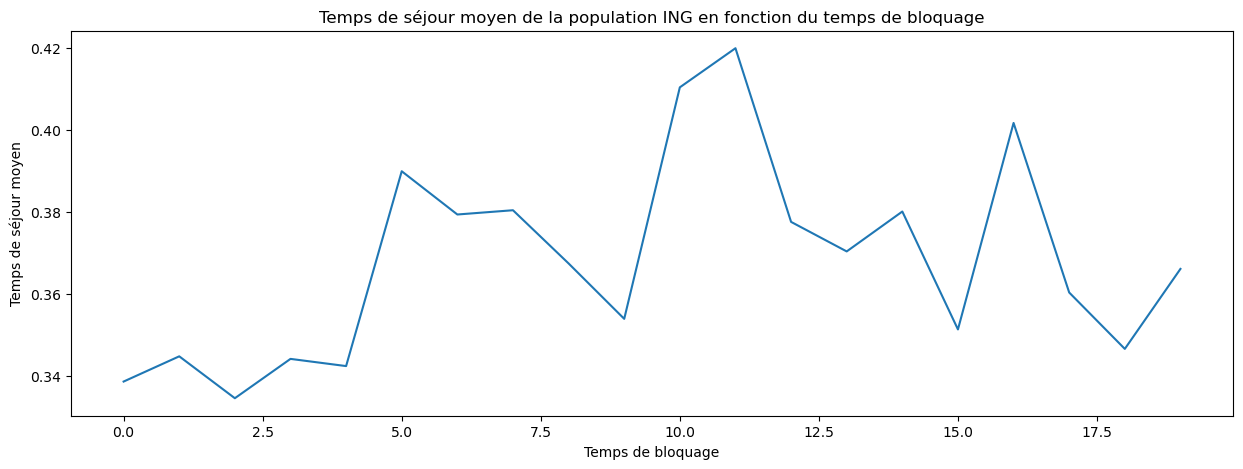

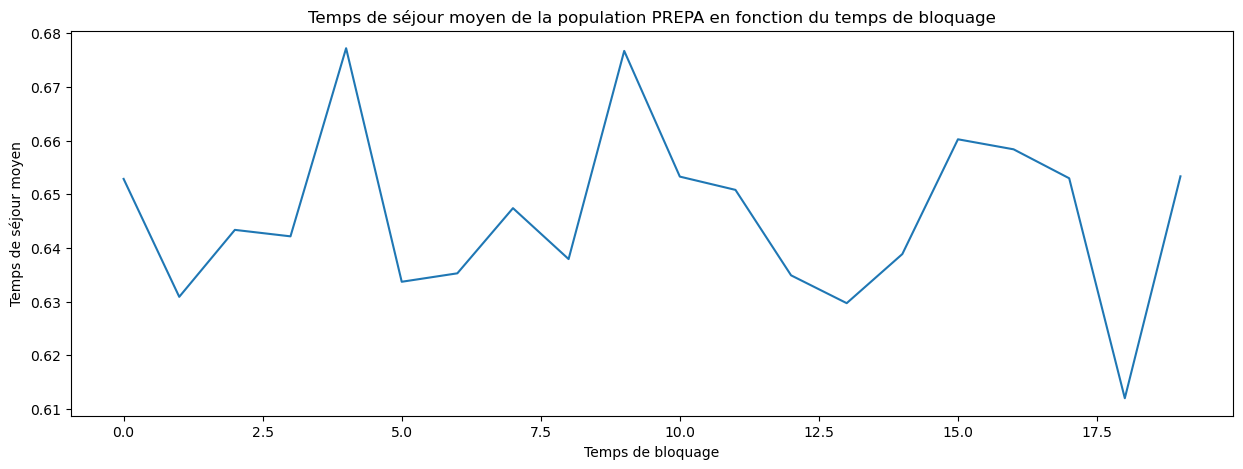

In [25]:
t_blocages = np.arange(0,20)

lambda_arr_ing = 4  # Taux d'arrivée des pushs population ing
lambda_arr_prepa = 2 # Taux d'arrivée des pushs population prepa
mu_1_ing = 3.2 # Taux de service des serveurs population ing
mu_1_prepa = 1.6 # Taux de service des serveurs population prepa
K = 4            # Nombre de serveurs
gen = np.random.default_rng(seed=42)
z = 5000
Ks = 6 # Taille maximale de la file pour M/M/K (SANS le nombre de serveurs)

result =[]
for t in t_blocages:
    gen = np.random.default_rng(seed=42)
    mmk_queue_dams = mmk_finite_two_populations_and_dams(lamda_ing=lambda_arr_ing, lamda_prepa=lambda_arr_prepa,mu_ing=mu_1_ing, mu_prepa=mu_1_prepa, k=K, Ks=Ks, gen=gen,t_blocage=t, test_z=z)
    
    mmk_queue_dams.run()
    
    stats = mmk_queue_dams.stats()
    
    clear_output(wait=True)
    
    # Calculer les statistiques pour chaque population
    ing_stats = stats[stats['Population'] == 'ING'].iloc[0]
    prepa_stats = stats[stats['Population'] == 'PREPA'].iloc[0]
    
    result.append({
        't_blocage': t,
        'ing_sojourn': ing_stats['Mean Sojourn Time'],
        'prepa_sojourn': prepa_stats['Mean Sojourn Time']
    })
results_df = pd.DataFrame(result)

# Visualisation des résultats
plt.figure(figsize=(15, 5))


plt.plot(t_blocages, results_df['ing_sojourn'])
plt.title('Temps de séjour moyen de la population ING en fonction du temps de bloquage')
plt.xlabel('Temps de bloquage')
plt.ylabel('Temps de séjour moyen')
plt.show()

plt.figure(figsize=(15, 5))

plt.plot(t_blocages, results_df['prepa_sojourn'])
plt.title('Temps de séjour moyen de la population PREPA en fonction du temps de bloquage')
plt.xlabel('Temps de bloquage')
plt.ylabel('Temps de séjour moyen')

plt.show()

On remarque que le temps de bloquage est un minimun local à 18.

Pour comparer les deux implémentation des M/M/K, on utilisera les paramètres optimisés trouvez dans la question précedente.

In [28]:
t_blocage = 18
gen = np.random.default_rng(seed=42)
# Créer une instance de la file M/M/K
mmk_queue = mmk_finite_two_populations(lamda_ing=lambda_arr_ing, lamda_prepa=lambda_arr_prepa,mu_ing=mu_1_ing, mu_prepa=mu_1_prepa, k=K, Ks=Ks, gen=gen, test_z=z)


mmk_queue_dams = mmk_finite_two_populations_and_dams(lamda_ing=lambda_arr_ing, lamda_prepa=lambda_arr_prepa,mu_ing=mu_1_ing, mu_prepa=mu_1_prepa, k=K, Ks=Ks, gen=gen,t_blocage=t_blocage, test_z=z)

mmk_queue.run()

mmk_queue_dams.run()

# Afficher les statistiques
print("\nStatistiques de la file M/M/K:")
print(mmk_queue.stats())

print("\nStatistiques de la file M/M/K avec blocage:")
print(mmk_queue_dams.stats())

Lancement de la simulation M/M/K pour deux populations


/tmp/ipykernel_5786/825909133.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'PREPA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Lancement de la simulation M/M/K pour deux populations


/tmp/ipykernel_5786/1810373514.py:105: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'PREPA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population



Statistiques de la file M/M/K:
  Population  Mean Waiting Time  Mean Service Time  Mean Sojourn Time  \
0        ING           0.079156           0.308907           0.388063   
1      PREPA           0.041292           0.616993           0.658285   

   Refused Pushes  
0              24  
1               8  

Statistiques de la file M/M/K avec blocage:
  Population  Mean Waiting Time  Mean Service Time  Mean Sojourn Time  \
0        ING           0.064934           0.307894           0.372828   
1      PREPA           0.020683           0.624817           0.645500   

   Refused Pushes  
0            1703  
1               1  


On remarque que le temps moyen de séjour de la population PREPA ne change pas avec l'implémentation du temps de bloquage contrairement à la population ING qui a une réduction de 0.04

Pour réduire le temps moyen de séjour, on pourrait introduire un système de priorité dynamiques en fonction des charatéristiques de chaque population. Ou bien, un systéme de quota.